In [1]:
import matplotlib.style
matplotlib.style.use('classic')
#import matplotlib
#matplotlib.use("pdf")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import click
import scipy as sp
from pypower.api import ppoption, runpf, printpf, makeYbus
from pypower.idx_gen import PG, QG, GEN_BUS
from pypower.idx_bus import PD, QD, VM, VA, BUS_I
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
import grid_cases as gridcase
from scipy.integrate import odeint
from scipy.interpolate import griddata
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def kuramoto_2nd_order( x, t, P, K, alfs ):
    N = int(len( P ))
    theta = x[:N]
    dot_theta = x[N:]
    dotdot_theta = np.zeros( 2*N )
    dotdot_theta[0:N] = dot_theta
    dotdot_theta[N:] = P - np.multiply( alfs, dot_theta ) + np.sum(K * np.sin( np.repeat( theta.reshape(N,1).T, N, axis=0 ) - np.repeat( theta.reshape(N,1), N, axis=1 ) ), axis=1)

    return dotdot_theta

In [213]:
K = 0.5*np.array([ [0, 1], [1, 0] ])
P = np.array([ 1.0, -1.0 ] )
alfs = np.ones(2)

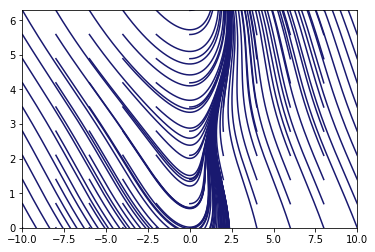

In [214]:
t = np.linspace(0, 10, 1000)

plt.figure()

for x0_1 in np.linspace(0, 2*np.pi, 10):
    for v0_1 in np.linspace(-10, 10, 11):
        x0 = np.array( [x0_1, 0.0, v0_1, 0.0] )
        states = odeint( kuramoto_2nd_order, x0, t, args=(P, K, alfs) )
        delta_theta = -states[:,1] + states[:,0]
        delta_dot_theta = -states[:,3] + states[:,2]
        plt.plot( delta_dot_theta, delta_theta, color = 'midnightblue' )
    
plt.ylim( [0, 2*np.pi] )
plt.xlim([-10, 10])
plt.show()

In [210]:
%matplotlib inline

# Triangular Network

In [42]:
from scipy.optimize import fsolve

def find_equilibria( dynamical_system, x_range, y_range, P, K, alfs):

    equilibria = list()
    for s_i in x_range:
        for i_i in y_range:

            x0 = [s_i, i_i, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
            
            x_sol, info_dict, ier, msg = fsolve( dynamical_system, x0, 
                                                args = (0, P, K, alfs), xtol = 1e-7, maxfev = 100000, full_output = True)
            if (ier == 1):
                jacob = info_dict['fjac']
                eigvals = np.linalg.eig( jacob )[0]

                if (np.any( np.real(eigvals) >= 0 )):
                    equilibria.append( [x_sol, 'unstable']  )
                else:
                    equilibria.append( [x_sol, 'stable']  )

    equilibria = np.array(equilibria)

    return equilibria



In [38]:
# Triangular
K = 8*np.array([ [0.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, 0.0] ])
P = np.array([ 1.0, -1.0, 0.0 ] )
alfs = np.zeros(3)
N = 3

In [59]:
# Triangular modified
#genat0 K = 8*np.array([ [0.0, 1.0, 1.0, 1.0], [1.0, 0.0, 1.0, 0.0], [1.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0] ])
#genat1 K = 8*np.array([ [0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0] ])
K = 8*np.array([ [0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 1.0, 0.0], [1.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0] ])
P = np.array([ 0.5, -1.0, 0.0, 0.5 ] )
N = len(P)
alfs = np.zeros(N)


In [60]:
x1 = np.linspace(-2*np.pi, 2*np.pi, 51)
x2 = np.linspace(-2*np.pi, 2*np.pi, 51)
equilibria = find_equilibria( kuramoto_2nd_order, x1, x2, P, K, alfs)


<IPython.core.display.Javascript object>


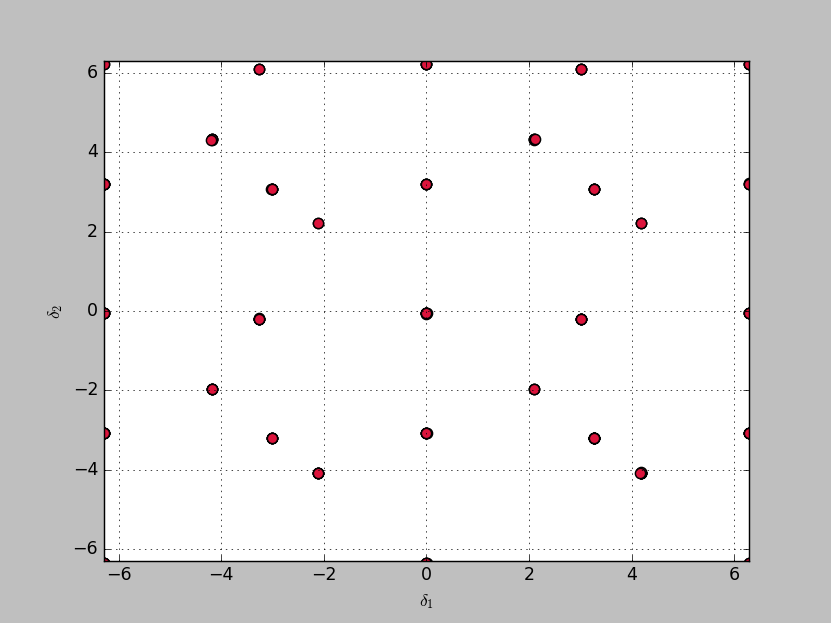

In [61]:
plt.figure()
for each_eq in equilibria:
    if (each_eq[1] == 'unstable') and (each_eq[0][2] < 0.01) and (each_eq[0][2] > -0.01):
        plt.scatter( each_eq[0][0], each_eq[0][1], c = 'crimson', s = 50 )
    elif (each_eq[1] == 'stable'):
        plt.scatter( each_eq[0][0], each_eq[0][1], c = 'lime', s = 50 )
        print(each_eq[0][0], each_eq[0][1])
plt.ylim([-2*np.pi, 2*np.pi])
plt.xlim([-2*np.pi, 2*np.pi])
plt.xlabel('$\delta_1$')
plt.ylabel('$\delta_2$')
plt.grid()
plt.savefig('Images/Equilibria_Triangular_modif_genat2.pdf')
plt.show()

In [4]:
%matplotlib notebook

In [30]:
vs = list()
for eq in equilibria:
    vs.append([each_eq[0][3], each_eq[0][4],each_eq[0][5]])
vs = np.array(vs)

print(vs.max())

5.860452775562057e-25


<IPython.core.display.Javascript object>


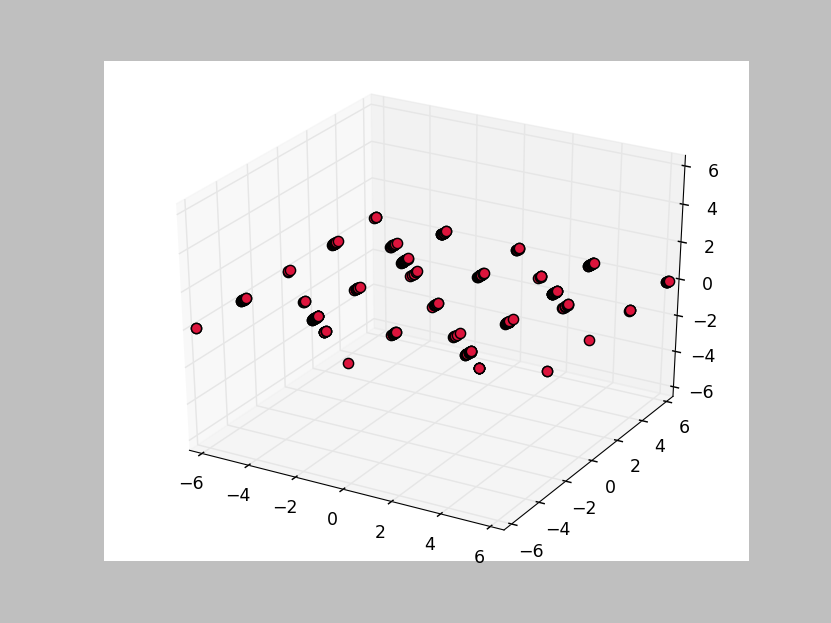

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

for each_eq in equilibria:
    if (each_eq[1] == 'unstable') and (each_eq[0][0] < 2*np.pi) and (each_eq[0][0] > -2*np.pi) and (each_eq[0][1] < 2*np.pi) and (each_eq[0][1] > -2*np.pi) and (each_eq[0][2] < 0.1) and (each_eq[0][2] > -0.1):  #and (np.abs(each_eq[0][1] + each_eq[0][0]) < 0.1):
        ax.scatter( each_eq[0][0], each_eq[0][1], each_eq[0][2], c = 'crimson', s = 50 )
    elif (each_eq[1] == 'stable'):
        ax.scatter( each_eq[0][0], each_eq[0][1], each_eq[0][2], c = 'lime', s = 50 )
        print(each_eq[0][0], each_eq[0][1])
ax.set_ylim([-2*np.pi, 2*np.pi])
ax.set_xlim([-2*np.pi, 2*np.pi])
ax.set_zlim([-2*np.pi, 2*np.pi])
ax.grid()
fig.show()

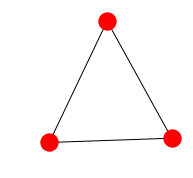

In [263]:
IM_Grapho = nx.from_numpy_matrix(K)
plt.figure(figsize=(2,2))
nx.draw(IM_Grapho)
plt.show()

In [330]:
x1 = np.linspace(-2*np.pi, 2*np.pi, 20)
x2 = np.linspace(-2*np.pi, 2*np.pi, 20)

points_max = 10000000
t = np.linspace(0, 1000, points_max)

In [331]:
x0 = np.array([np.pi, 0.0, 0.0, 0.0, 0.0, 0.0])
states = odeint( kuramoto_2nd_order, x0, t, args=(P, K, alfs) )

In [ ]:
plt.figure()
plt.plot( t, states[:,:3] )
#plt.xlim([0,20])
#plt.ylim([-20, 20])
plt.show()

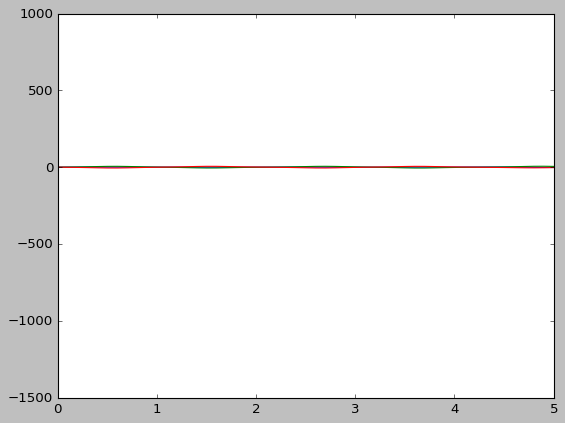

0.9796685279399149


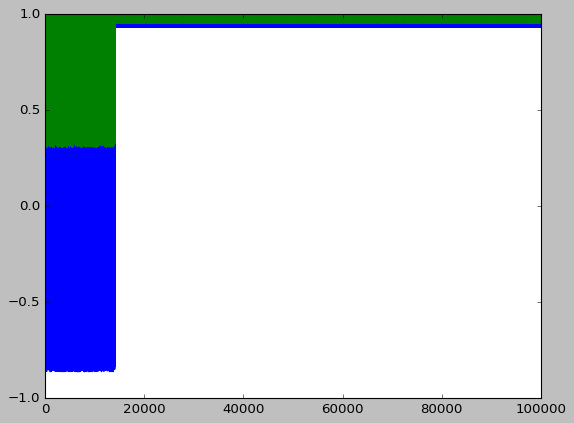

In [294]:



plt.figure()
plt.plot( t, states[:,3:] )
plt.xlim([0, 5])
plt.show()

real_r = (np.sum( np.cos( states[:,0:N] ), axis = 1 ))/N
imag_r = (np.sum( np.sin( states[:,0:N] ), axis = 1 ))/N
mag_r = np.sqrt(np.square(real_r) + np.square(imag_r))
mean_real_r = np.mean( real_r[ int(np.floor(points_max/2)) : ] )
mean_mag_r = np.mean( mag_r[ int(np.floor(points_max/2)) : ] )


plt.figure()
plt.plot(real_r)
plt.plot(mag_r)
plt.plot()
print(mean_mag_r)

0.8738378589036586


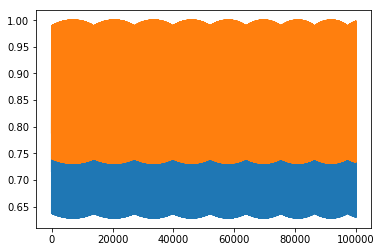

In [268]:

points = list()
sim_count = 0
sim_prog = 0

for x0_1 in x1:
    for x0_2 in x2:
        x0 = np.array([x0_1, x0_2, 0.0, 0.0, 0.0, 0.0])
        states = odeint( kuramoto_2nd_order, x0, t, args=(P, K, alfs) )
        
        real_r = (np.sum( np.cos( states[:,0:N] ), axis = 1 ))/N
        imag_r = (np.sum( np.sin( states[:,0:N] ), axis = 1 ))/N
        mag_r = np.sqrt(np.square(real_r) + np.square(imag_r))
        mean_real_r = np.mean( real_r[ int(np.floor(points_max/2)) : ] )
        mean_mag_r = np.mean( mag_r[ int(np.floor(points_max/2)) : ] )
        phase_velocity_sq = np.square( states[int(np.floor(points_max/2)):,N:] )
        v_inf = np.mean(np.mean( phase_velocity_sq, axis = 1), axis = 0 )        
        
        points.append( [(x0[0]), (x0[1]), mean_real_r, mean_mag_r, np.sqrt(v_inf)] )
        
        sim_count = sim_count + 1
        print('Progress: ', sim_count/((len(x1))*(len(x1))))
points = np.array(points)

Progress:  0.0025
Progress:  0.005
Progress:  0.0075
Progress:  0.01


/home/cristian/.local/lib/python3.5/site-packages/scipy/integrate/odepack.py:236: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



Progress:  0.0125
Progress:  0.015
Progress:  0.0175
Progress:  0.02
Progress:  0.0225
Progress:  0.025
Progress:  0.0275
Progress:  0.03
Progress:  0.0325
Progress:  0.035
Progress:  0.0375
Progress:  0.04
Progress:  0.0425
Progress:  0.045
Progress:  0.0475
Progress:  0.05
Progress:  0.0525
Progress:  0.055
Progress:  0.0575
Progress:  0.06
Progress:  0.0625
Progress:  0.065
Progress:  0.0675
Progress:  0.07
Progress:  0.0725
Progress:  0.075
Progress:  0.0775
Progress:  0.08
Progress:  0.0825
Progress:  0.085
Progress:  0.0875
Progress:  0.09
Progress:  0.0925
Progress:  0.095
Progress:  0.0975
Progress:  0.1
Progress:  0.1025
Progress:  0.105
Progress:  0.1075
Progress:  0.11
Progress:  0.1125
Progress:  0.115
Progress:  0.1175
Progress:  0.12
Progress:  0.1225
Progress:  0.125
Progress:  0.1275
Progress:  0.13
Progress:  0.1325
Progress:  0.135
Progress:  0.1375
Progress:  0.14
Progress:  0.1425
Progress:  0.145
Progress:  0.1475
Progress:  0.15
Progress:  0.1525
Progress:  0.155


In [269]:
x_ax = points[:, 0]
y_ax = points[:, 1]


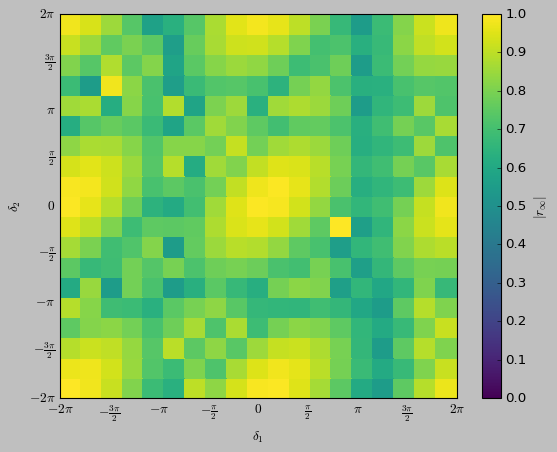

In [276]:
X_space, Y_space = np.meshgrid( np.sort(np.unique(x_ax)), np.sort(np.unique(y_ax)) ) 

fig = plt.figure()
ax1 = fig.add_subplot(111)
values = points[:,3]
Z_space = griddata(points[:,0:2], values, (X_space, Y_space), method ='nearest' )
im = ax1.pcolormesh( X_space, Y_space, Z_space, cmap = plt.cm.viridis, vmin = 0, vmax = 1, edgecolors = 'face')
cbar = fig.colorbar(im, ax = ax1)
cbar.set_label(r'$|r_{\infty}|$')

ax1.set_xlabel(r'$\delta_1$')
ax1.set_xticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_xticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_yticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_yticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_ylabel(r'$\delta_2$')
ax1.set_xlim([-2*np.pi, 2*np.pi])
ax1.set_ylim([-2*np.pi, 2*np.pi])
ax1.xaxis.set_ticks_position('none') 
ax1.yaxis.set_ticks_position('none') 
plt.savefig('Images/var_initstate_triangular_rinf.pdf')
plt.show()

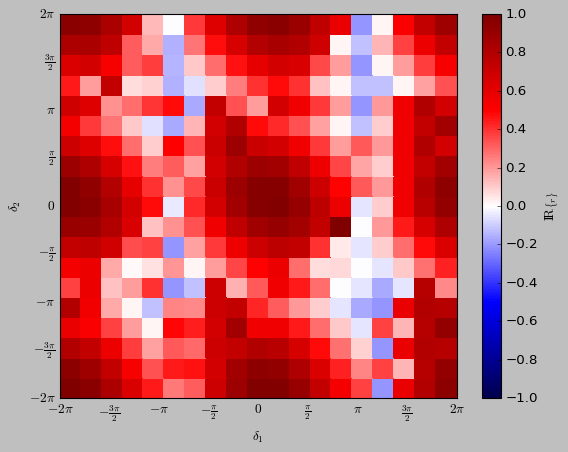

In [277]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

values = points[:,2]
Z_space = griddata(points[:,0:2], values, (X_space, Y_space), method ='nearest' )
im = ax1.pcolormesh( X_space, Y_space, Z_space, cmap = plt.cm.seismic, vmin = -1, vmax = 1, edgecolors = 'face')
cbar = fig.colorbar(im, ax = ax1)
cbar.set_label(r'${\rm I\!R}_{ \{ r \} }$')
ax1.set_xlabel(r'$\delta_1$')
ax1.set_xticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_xticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_yticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_yticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_ylabel(r'$\delta_2$')
ax1.set_xlim([-2*np.pi, 2*np.pi])
ax1.set_ylim([-2*np.pi, 2*np.pi])
ax1.xaxis.set_ticks_position('none') 
ax1.yaxis.set_ticks_position('none') 
plt.savefig('Images/var_initstate_triangular_rreal.pdf')
plt.show()

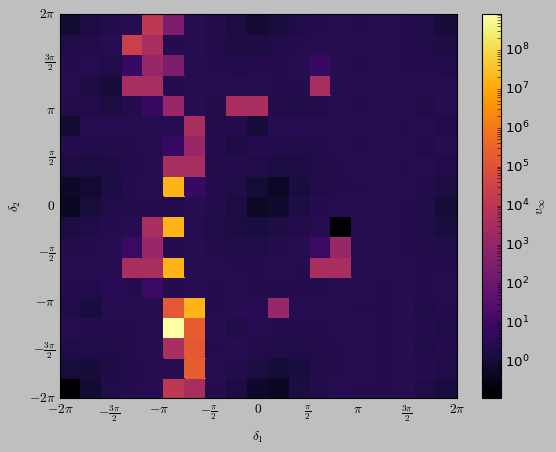

In [292]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
values = points[:,4]
Z_space = griddata(points[:,0:2], values, (X_space, Y_space), method ='nearest' )
im = ax1.pcolormesh( X_space, Y_space, Z_space, cmap = plt.cm.inferno, edgecolors = 'face', norm=colors.LogNorm(vmin=values.min(), vmax=values.max()))
cbar = fig.colorbar(im, ax = ax1)
cbar.set_label(r'$v_{\infty}$')
ax1.set_xlabel(r'$\delta_1$')
ax1.set_xticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_xticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_yticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_yticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_ylabel(r'$\delta_2$')

ax1.xaxis.set_ticks_position('none') 
ax1.yaxis.set_ticks_position('none') 

ax1.set_xlim([-2*np.pi, 2*np.pi])
ax1.set_ylim([-2*np.pi, 2*np.pi])
plt.savefig('Images/var_initstate_triangular_vinf.pdf')
plt.show()

In [80]:
K = 1.1*np.array([ [0, 1], [1, 0] ])
P = np.array([ [1.0], [-1.0] ] )
alfs = np.ones(2)
Graph_net = nx.from_numpy_matrix( K )
theta_ss, max_diff = synch_condition( Graph_net, K, P )

print(theta_ss, '\n \n', max_diff)

[[ 0.45454545]
 [-0.45454545]] 
 
 2.220446049250313e-16


In [3]:
def synch_condition( G, K, w ):
    L_dagger = np.linalg.pinv( nx.laplacian_matrix( G ).todense() )
    B = nx.incidence_matrix( G ).todense()
    theta_ss = np.matmul(L_dagger, w) 
    max_diff = np.linalg.norm( np.matmul( B.T, theta_ss.T ), np.inf )
    return theta_ss, max_diff

In [56]:
K = 1.3*np.loadtxt( 'params_COL/K_Colombia_pu.txt' )
P = np.loadtxt( 'params_COL/P_Colombia_pu.txt' )
#Alf = np.loadtxt( 'params_COL/alf_Colombia_pu.txt' )
Alf = 0.1*np.ones( P.shape )
Graph_net = nx.from_numpy_matrixb
print(nx.is_connected( Graph_net ))
theta_ss, max_diff = synch_condition( Graph_net, K, P )

print(theta_ss, '\n \n', max_diff)

True
[[ 0.70149     1.27620336  1.11049651  0.40420483  0.3699687   0.28745909
   0.73809598 -3.9115778   0.84907542 -0.62331431 -0.88564004 -1.47612706
   0.76523084  1.46448373 -1.37545973 -0.9951792  -4.21623988 -1.27182088
   0.25095538  0.20889907 -0.35715753  1.4045715  -0.78328424  1.61199431
  -0.51589283  0.86978868 -1.62525232 -2.36280051 -2.04936051 -1.47229612
  -1.43866625  0.94147864  0.42808078  0.40890017 -1.21853342  1.07142666
  -1.90995376  0.63931858 -0.60013993  1.77135258  0.59421511  0.86978868
   1.04185891  0.68383983  0.46036216  1.50059994  0.2689568   0.9912974
   1.54770702  0.37123545  0.83352752  0.34081194 -1.36520459  0.07101743
  -0.45072363  0.85317818  0.53795034  1.05356981  1.02533543  0.74966877
  -1.22927616  0.6130611   0.3039445   0.74057987  0.50492888  0.80503099
   1.67127373  0.12318194  0.97501106  1.32588386  0.6871708  -0.21999813
   0.54481343  0.60239727  1.60618235  0.46870156 -0.85572242  1.06617295
  -3.30225363  1.03599528  0.41330

/home/yggdrasil/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


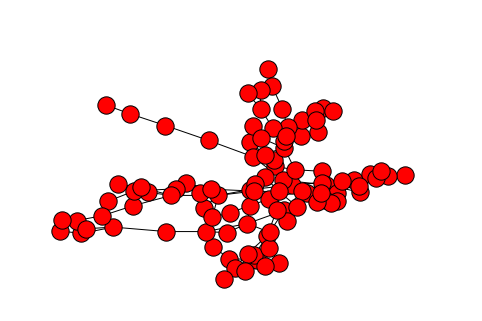

In [64]:
pos = nx.spring_layout(Graph_net )
nx.draw(Graph_net, pos)

In [66]:
np.sum(K != 0)

317

In [75]:
P

array([-0.61943895, -0.61943895,  2.04      , -0.61943895, -0.61943895,
       -0.61943895, -0.61943895, -0.61943895, -0.61943895,  0.04      ,
       -0.61943895, -0.61943895, -0.61943895,  3.24      , -0.61943895,
       -0.61943895, -0.61943895,  0.137     , -0.61943895, -0.61943895,
       -0.61943895,  6.        , -0.61943895, -0.61943895, -0.61943895,
       -0.61943895, -0.61943895, -0.61943895, -0.61943895, -0.61943895,
       -0.61943895, -0.61943895, -0.61943895, -0.61943895, -0.61943895,
        1.212     ,  0.286     ,  3.36      , -0.61943895,  7.278     ,
        1.02      , -0.61943895, -0.61943895, -0.61943895, -0.61943895,
        1.944     , -0.61943895, -0.61943895, -0.61943895,  0.46      ,
        0.63      , -0.61943895, -0.61943895, -0.61943895,  0.167     ,
        2.376     , -0.61943895, -0.61943895, -0.61943895, -0.61943895,
       -0.61943895, -0.61943895, -0.61943895, -0.61943895,  0.321     ,
       -0.61943895,  1.656     , -0.835518  , -0.61943895,  2.7 

In [ ]:
# MULTIPROCESSING! 

In [81]:
np.argmin(P)

67

In [82]:
np.min(P)

-0.8355179999999999

In [80]:
102 - np.sum(P > 0)

75

In [74]:
K.diagonal() != 0


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [57]:
points_max = 10000
t = np.linspace(0, 100, points_max)

x0 = np.concatenate((theta_ss, 0*theta_ss), axis=1).T
y0 = x0.flatten()
y0 = y0.tolist()
y0 = y0[0]
states = odeint( kuramoto_2nd_order, y0, t, args=(P, K, Alf) )

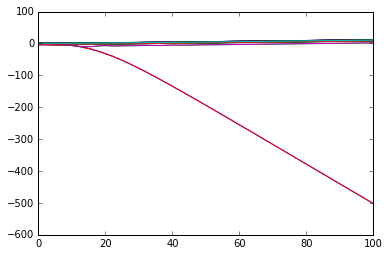

In [58]:
plt.figure
plt.plot(t, states[:,0:102])
#plt.xlim([0,10])
#plt.ylim([-20,20])
plt.show()

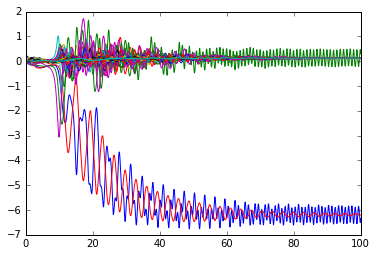

In [59]:
plt.figure
plt.plot(t, states[:,102:])
#plt.xlim([0,10])
#plt.ylim([-20,20])
plt.show()

In [11]:
np.sum(P)

-1.2656542480726785e-14

In [15]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [16]:
check_symmetric(K)

True